# Read data from Rigol DS1054Z scope

https://readthedocs.org/projects/ds1054z/downloads/pdf/stable/

### Import the libraries

In [18]:
from ds1054z import DS1054Z
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import scipy.signal as sig
import pyvisa as visa
import time
import os
import shutil

### Verify scope connection

In [2]:
scope = DS1054Z('192.168.1.206')

In [3]:
print(scope.idn)

RIGOL TECHNOLOGIES,DS1054Z,DS1ZA200902668,00.04.04.SP3


### Setup the test sequence

This is the final directory name for the files

In [4]:
str_data_dir = 'LatheNoChuck001'
idx_data_dir = [1,2,3,4,5,6];

Current needs to be on channel 1 and voltage on channel 2 for the scripts to work

Setup the vertical and horizontal scales on the scope

In [68]:
d_ch1_scale = 0.02
d_ch2_scale = 0.20

scope.timebase_scale = 5E-2
scope.run()
scope.display_channel(1,enable=True)
scope.set_probe_ratio(1,1)
scope.set_channel_scale(1,"{:e}".format(d_ch1_scale) +'V')
scope.write(':CHANnel1:COUPling AC')

scope.display_channel(2,enable=True)
scope.set_probe_ratio(2,1)
scope.set_channel_scale(2,"{:e}".format(d_ch2_scale) +'V')
scope.write(':CHANnel2:COUPling AC')

scope.write(':trigger:edge:source CHAN2')
scope.write(':trigger:edge:level 0e+01')
scope.single()


Aquire the data

In [69]:
d_ch1 = scope.get_waveform_samples(1,mode='NORM')
d_ch2 = scope.get_waveform_samples(2,mode='NORM')
scope.run()
scope.write(":TRIGger:SWEep AUTO")

Plot the data

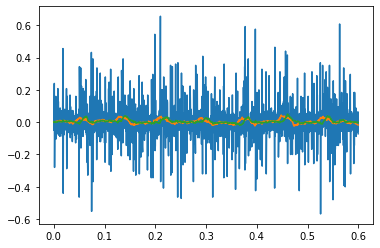

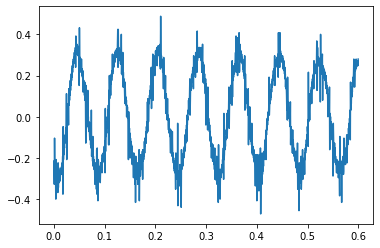

In [70]:
ns = len(d_ch1)
d_t_del = (12*scope.timebase_scale)/ns
t = np.linspace(0,(ns-1),ns)*d_t_del
d_fs = 1/(t[2]-t[1])

# List to numpy array
d_np_ch1 = np.array(d_ch1)
d_np_ch2 = np.array(d_ch2)

# scale and plot
d_np_ch1 = d_np_ch1*10.0;
d_np_ch1_filt = sig.savgol_filter(d_np_ch1, 51, 1)
d_wn = 100
sos = sig.butter(1, 10, btype='low', fs=d_fs, output = 'sos')
d_np_ch1_filt1 = sig.sosfilt(sos, d_np_ch1)

plt.plot(t,d_np_ch1)
plt.plot(t, d_np_ch1_filt)
plt.plot(t, d_np_ch1_filt1)
plt.show()
plt.plot(t,d_np_ch2)
plt.show()

Save the data

In [71]:
str_file = 'test005' + '.csv'
file_data = open(str_file,'w+')
file_data.write('X,CH1,CH2,Start,Increment,\n')
str_line = 'Sequence,Volt,Volt,0.000000e-03,' + str(d_t_del)
file_data.write(str_line+'\n')

for idx_line in range(0,ns):
    str_line = str(idx_line) + ',' + '%0.5f' % d_ch1[idx_line] + ',' + '%0.5f' % d_ch2[idx_line] + ','
    file_data.write(str_line+'\n')

file_data.close()

### Read data from the scope

In [ ]:
for idx_test_set in idx_data_dir:
    
    print ("Working on test index: " + str(idx_test_set))
    
    # Reset channel scales
    d_ch1_scale = 0.5
    d_ch2_scale = 0.05
    
    for idx_lst in range(0,ns_test):

        str_command_freq = 'source1:frequency ' + str(lst_freq[idx_lst])
        afg.write(str_command_freq)
        str_command_offset = 'source1:voltage:level:immediate:offset ' + str(d_offset)
        afg.write(str_command_offset)
        str_command_amp = 'source1:voltage:level:immediate:amplitude ' + str(d_amp)
        afg.write(str_command_amp)

        scope.timebase_scale = lst_timebase_scale[idx_lst]
        scope.run()
        scope.display_channel(1,enable=True)
        scope.set_probe_ratio(1,1)
#        scope.set_channel_scale(1,"{:e}".format(lst_ch1_scale[idx_lst]) +'V')
        scope.set_channel_scale(1,"{:e}".format(d_ch1_scale) +'V')
        scope.display_channel(2,enable=True)
        scope.set_probe_ratio(2,1)
        scope.set_channel_scale(2,"{:e}".format(d_ch2_scale) +'V')

        scope.write(':trigger:edge:source CHAN2')
        scope.write(':trigger:edge:level 0e+01')
        scope.single()

        d_ch1 = scope.get_waveform_samples(1,mode='NORM')
        d_ch2 = scope.get_waveform_samples(2,mode='NORM')
        scope.run()
        scope.write(":TRIGger:SWEep AUTO")
        
        # Update the scale
        d_ch1_scale = (max(d_ch1) - min(d_ch1))/5
        d_ch2_scale = (max(d_ch2) - min(d_ch2))/5

        ns = len(d_ch1)
        d_t_del = (12*scope.timebase_scale)/ns
        t = np.linspace(0,(ns-1),ns)*d_t_del

        plt.plot(t,d_ch1)
        plt.plot(t,d_ch2)
        plt.show()

        str_file = lst_tests[idx_lst] + '.csv'
        file_data = open(str_file,'w+')
        file_data.write('X,CH1,CH2,Start,Increment,\n')

        str_line = 'Sequence,Volt,Volt,0.000000e-03,' + str(d_t_del)
        file_data.write(str_line+'\n')

        for idx_line in range(0,ns):
            str_line = str(idx_line) + ',' + '%0.5f' % d_ch1[idx_line] + ',' + '%0.5f' % d_ch2[idx_line] + ','
            file_data.write(str_line+'\n')

        file_data.close()

        idx_lst = idx_lst + 1
        if (idx_lst>(ns_test-1)):
            idx_lst = (ns_test-1)
            print('All test completed')
        else:
            # Update the file name
            print('Finished: ' + str_file + '. Next is ' + lst_tests[idx_lst])

        time.sleep(0.1)

    # Move the files around
    os.system('ScopeDataToStruct.bat')
    time.sleep(120)
    
    # Construct the string and get rid of the directory if it exists
    str_dir = str_data_dir + str(idx_data_dir[idx_test_set-1]).zfill(3)
    print(str_dir)
    if (os.path.isdir(str_dir)):
            shutil.rmtree(str_dir)
    time.sleep(3)
    os.mkdir(str_dir)
    os.system('movefiles ' + str_dir)

In [ ]:
idx_test_set

Make the directory and copy over the files